In [1]:
import pandas as pd
import requests
import plotly.graph_objects as go
import numpy as np
import GMX_data as gmx
import plotly.io as pio
pio.renderers.default = "browser"

浮动币 ： ['UNI', 'LINK', 'ETH', 'WBTC']

In [3]:
symbol = gmx.get_token()
actions = gmx.get_actions()
end_day = '202370200'

In [4]:
glp = gmx.get_glp(end_day)
fee = gmx.get_fee(end_day)
prc = gmx.get_fast_price(symbol,end_day,token_list = ['ETH',"WBTC"])
result,fig,data,indicators = gmx.show_case(glp,fee,prc, [0.286137,0.223263])
fig.show()

apy:  0.2908080548943913
sharpe:  4.1982651245651965
max drawdown:  -0.045698695055966354 end at:  2023-03-11 07:00:00


In [ ]:
# glp price
glp.plot(x = 'time',y = 'price',figsize = (20,10),title = 'GLP price')

In [ ]:
result['hedge_value'] = result['eth_value'] + result['wbtc_value']
result[['glp_value','eth_value','wbtc_value','hedge_value']].corr()

In [ ]:
result.shape

In [7]:
import json

token_list = ['USDC.e', 'USDT', 'UNI', 'LINK', 'DAI', 'ETH', 'WBTC','FRAX']
address_list = [x for x in symbol.index if symbol.loc[x,'data.symbol'] in token_list]
data = pd.DataFrame()
for address in address_list:
    query = f'''{{
    tokenStats(first: 1000, orderBy: timestamp, orderDirection: desc, where: {{ period: "hourly", timestamp_lt: 1800000000, timestamp_gt: 0, token: "{address}" }}) {{
        id
        token
        poolAmount
        poolAmountUsd
        usdgAmount
        reservedAmount
        reservedAmountUsd
        timestamp
        period
    }}
    }}
    '''
    url = 'https://subgraph.satsuma-prod.com/3b2ced13c8d9/gmx/gmx-arbitrum-stats/api'
    headers = {'Content-Type': 'application/json'}
    request_json = {'query': query}
    response = requests.post(url, headers=headers, data=json.dumps(request_json))
    response = response.json()
    if 'errors' in response:
        error_message = data['errors'][0]['message']
        raise Exception(f"GraphQL query failed: {error_message}")
    response = response['data']['tokenStats']
    response = pd.DataFrame(response)
    data = pd.concat([data,response],join = 'outer',axis = 0)


data['time'] = pd.to_datetime(data['timestamp'], unit='s')
data['token'] = data['token'].apply(lambda x: symbol.loc[x]['data.symbol'])
data['poolAmount'] = data['poolAmount'].astype(float) / 10**30
data['poolAmountUsd'] = data['poolAmountUsd'].astype(float) / 10**30
data['usdgAmount'] = data['usdgAmount'].astype(float) / 10**30
data['reservedAmount'] = data['reservedAmount'].astype(float) / 10**30
data['reservedAmountUsd'] = data['reservedAmountUsd'].astype(float) / 10**30
# 计算每个小时的各个币种的比例
# 取eth > 1的数据
cut_window = data[data['token'] == 'ETH'].copy()
data = data[data['time'] >= cut_window['time'].min()]
data['percentage'] = data['poolAmountUsd'] /data['time'].map(data.groupby('time')['poolAmountUsd'].sum())

In [16]:
# 重组成一个表
compo_data = data.pivot(index = 'time',columns = 'token',values = 'percentage')
compo_data.fillna(0,inplace = True)
# 画柱状图
# compo_data.plot(kind = 'bar',stacked = True,figsize = (20,10),title = 'GMX pool composition')

In [36]:
# 获得价格
prc = gmx.get_fast_price(symbol,end_day,['ETH',"WBTC","LINK","UNI"])

In [55]:
for key,value in prc.items():
    temp = value.set_index('time')
    compo_data['value.' + key.lower()] = temp['value.' + key.lower()]
compo_data = compo_data.dropna()

C:\Users\hanksong\AppData\Local\Temp/ipykernel_23496/664132479.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [56]:
# 合成指数
v0 = 10000
compo_value = v0 * 0.5 * 1/4 / compo_data[['value.wbtc','value.eth','value.uni','value.link']].iloc[0]
compo_data['index'] = (compo_value * compo_data[['value.wbtc','value.eth','value.uni','value.link']]).sum(axis = 1) + v0 * 0.5
compo_data 

token,DAI,ETH,FRAX,LINK,UNI,USDC.e,USDT,WBTC,value.wbtc,value.eth,value.uni,value.link,index
time,,,,,,,,,,,,,
2023-05-22 20:00:00,0.062861,0.280157,0.014700,0.005583,0.005539,0.432748,0.005177,0.193236,26901.46,1818.454,5.078,6.52,10000.000000
2023-05-22 21:00:00,0.000000,0.299394,0.015691,0.005979,0.005918,0.461445,0.005530,0.206043,26904.276,1821.014,5.087,6.517,10003.530870
2023-05-22 22:00:00,0.062859,0.280474,0.014711,0.005597,0.005548,0.432526,0.005227,0.193057,26874.65,1818.924,5.077,6.538,10002.282087
2023-05-22 23:00:00,0.062885,0.280396,0.014715,0.005603,0.005550,0.432707,0.005231,0.192914,26849.4,1817.424,5.075,6.533,9998.626819
2023-05-23 00:00:00,0.000000,0.299035,0.015694,0.005981,0.005904,0.462039,0.005606,0.205741,26826.105,1816.564,5.065,6.509,9989.890409
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-01 19:00:00,0.067476,0.278361,0.000000,0.006396,0.006475,0.369387,0.015935,0.255970,30619.22,1922.77,5.539,6.428,10340.297183
2023-07-01 20:00:00,0.067635,0.280230,0.000000,0.006508,0.000000,0.372070,0.016040,0.257517,30584.63,1922.5,5.548,6.464,10347.621611
2023-07-01 21:00:00,0.065774,0.272474,0.021291,0.006299,0.006329,0.361840,0.015601,0.250391,30589.52,1922.85,5.539,6.431,10339.547292


In [62]:
glp = gmx.get_glp(end_day)
glp = glp[(glp['time'] >= compo_data.index.min()) & (glp['time'] <= compo_data.index.max())]
glp.sort_values('time',inplace = True)
glp.set_index('time',inplace = True)


<AxesSubplot:title={'center':'GMX index vs GLP'}, xlabel='time'>

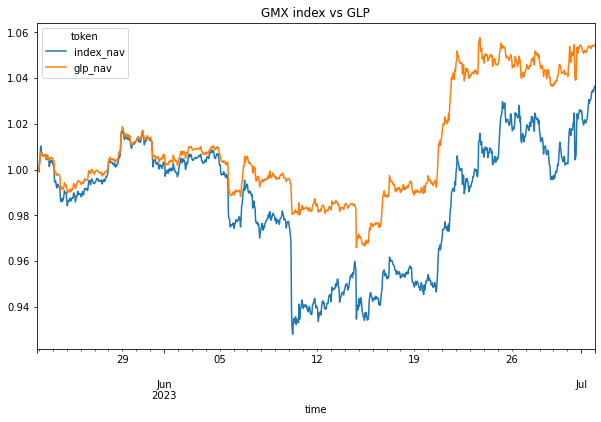

In [68]:
compo_data['index_nav'] = compo_data['index'] / compo_data['index'].iloc[0]
glp['glp_nav'] = glp['price'] / glp['price'].iloc[0]
compo_data['glp_nav'] = glp['glp_nav']
# 画图，白色背景
compo_data[['index_nav','glp_nav']].plot(figsize = (10,6),title = 'GMX index vs GLP')
